# Running the SBML PBK model with roadrunner

This notebook demonstrates how to run simulations with the SBML PBK model using the roadrunner library.

## Preparation

In [73]:
import roadrunner as rr
import pandas as pd
import math
import matplotlib.pyplot as plt
import libsbml as ls
from tabulate import tabulate

# Specify sbml file path
sbml_file = '../model/euromix.sbml'

# Specify the input species
oral_input = 'QGut'
dermal_input = 'QSkin_sc_e'
inhalation_input = 'QAir'

# Specify parametrisations file and instance id
param_file = '../parametrisations/parametrisations_euromix.csv'
param_instance_id = 'CosmosCypermethrin'
molar_mass = 416.3 # molar mass is not part of parametrisation


## Running the model

In [74]:
# Helper function for plotting simulation results
def plotSimulationResults(res, selections, ncols=4):
    nrows = math.ceil((len(selections) - 1)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()
    for ax in axes:
        ax.set(xlabel='time') 
    labels = selections
    for i in range(1, len(selections)):
        sid = selections[i]
        axes[i-1].plot(res['time'], res[sid], linewidth=1)
        axes[i-1].set(ylabel=f"Amount", title=labels[i])
    fig.tight_layout()

# Helper function for generating dosing event patterns
def generateDoseEventsPattern(amount, start, step, stop):
    timings = range(start, stop, step)
    events = []
    for timing in timings:
        events.append((timing, amount))
    return events

# Helper function for loading parametrisations
def loadParametrisation(model, filename, idInstance):
    df = pd.read_csv(filename)
    df['Value'] = df['Value'].astype(float)
    df = df.loc[df['idModelInstance'] == idInstance]
    for index, row in df.iterrows():
        model[str(row['Parameter'])] = row['Value']

## Report parametrisation

Load parametrisations from specified file and report the parameter values.

In [75]:
# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Load parametrisation
loadParametrisation(rr_model, param_file, param_instance_id)

# Get the SBML model
document = ls.readSBML(sbml_file)
model = document.getModel()

# Create parameters info table
dt_params = []
print("Number of parameters: " + str(model.getNumParameters()))
for i in range(0,model.getNumParameters()):
    s = model.getParameter(i)
    if (s.getConstant()):
        dt_params.append([
            s.getId(),
            rr_model[s.getId()],
            s.getUnits(),
            s.getName()
        ])
df_params = pd.DataFrame(
    dt_params,
    columns=["Id", "Value", "Unit", "Name"]
)
print(tabulate(df_params, headers="keys", tablefmt="fancy_grid", showindex=False))

Number of parameters: 42
╒═════════════╤════════════╤═══════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Id          │      Value │ Unit              │ Name                                                                       │
╞═════════════╪════════════╪═══════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ BM          │   70       │ KiloGM            │ body mass                                                                  │
├─────────────┼────────────┼───────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ BSA         │  190       │ DeciM2            │ body surface area                                                          │
├─────────────┼────────────┼───────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ Height_sc   │    0.0001  │ DeciM             │ thickness stratum corneum                   

### Single oral bolus

Single oral dose of 1 at $t_0$ fed as initial amount of the input compartment.

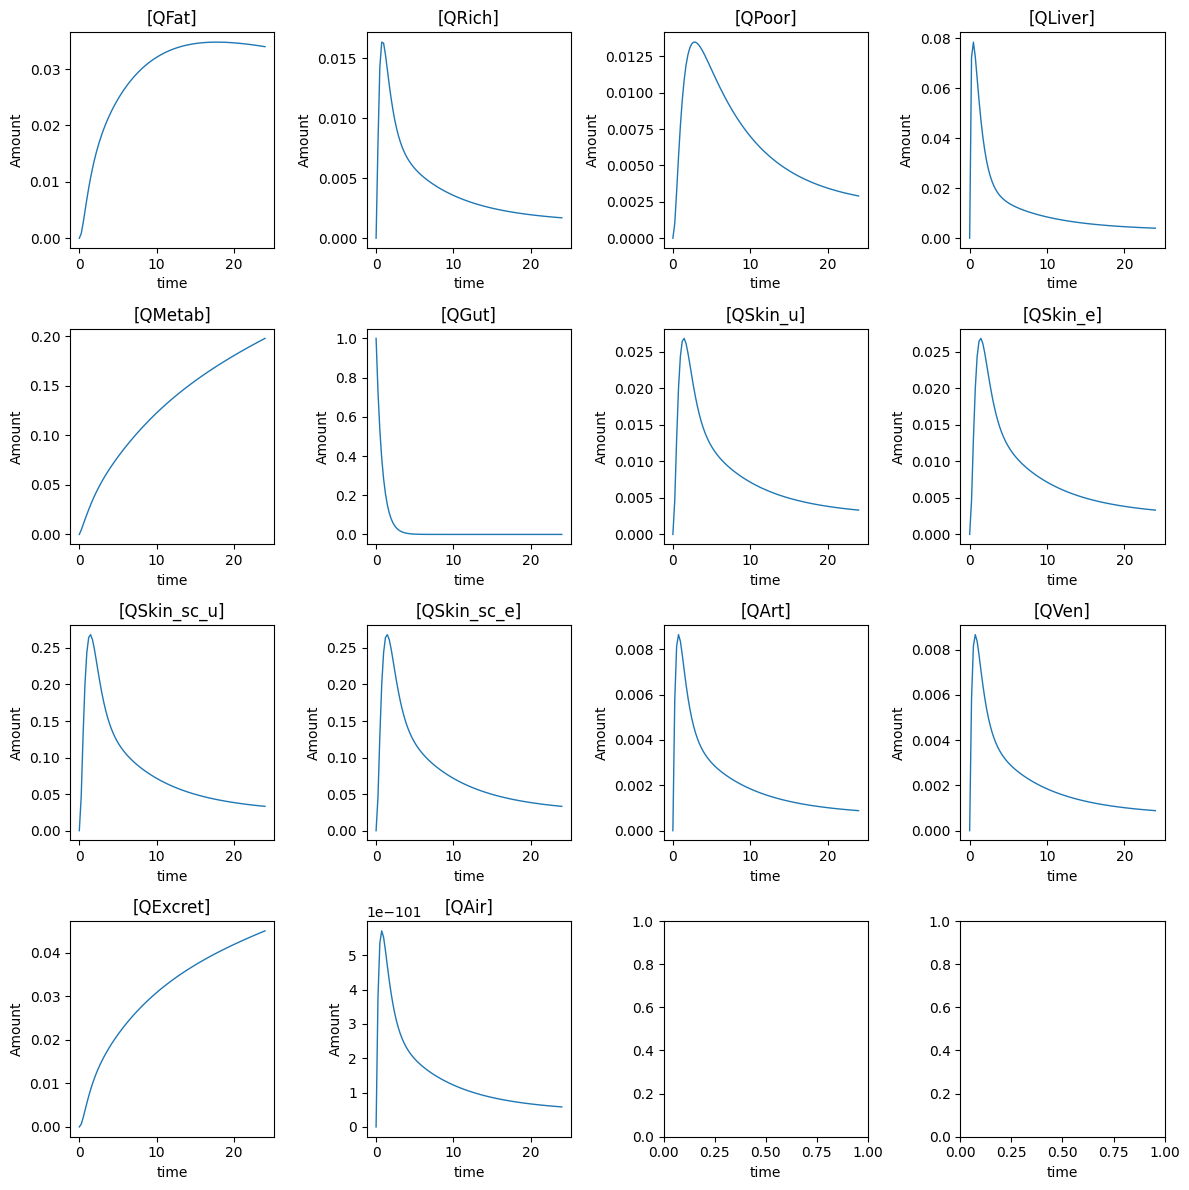

In [76]:
# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Set initial amount
rr_model.setInitAmount(oral_input, 1)
rr_model.setConstant(oral_input, False)
rr_model.setBoundary(oral_input, False)

# Load parametrisation
loadParametrisation(rr_model, param_file, param_instance_id)

# Simulate the PBPK model
results = rr_model.simulate(start=0, end=24, points=100)

# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)

### Continuous oral dose

Continuous dose of 1 set as initial amount, accomplished by setting the input compartment to boundary and constant.

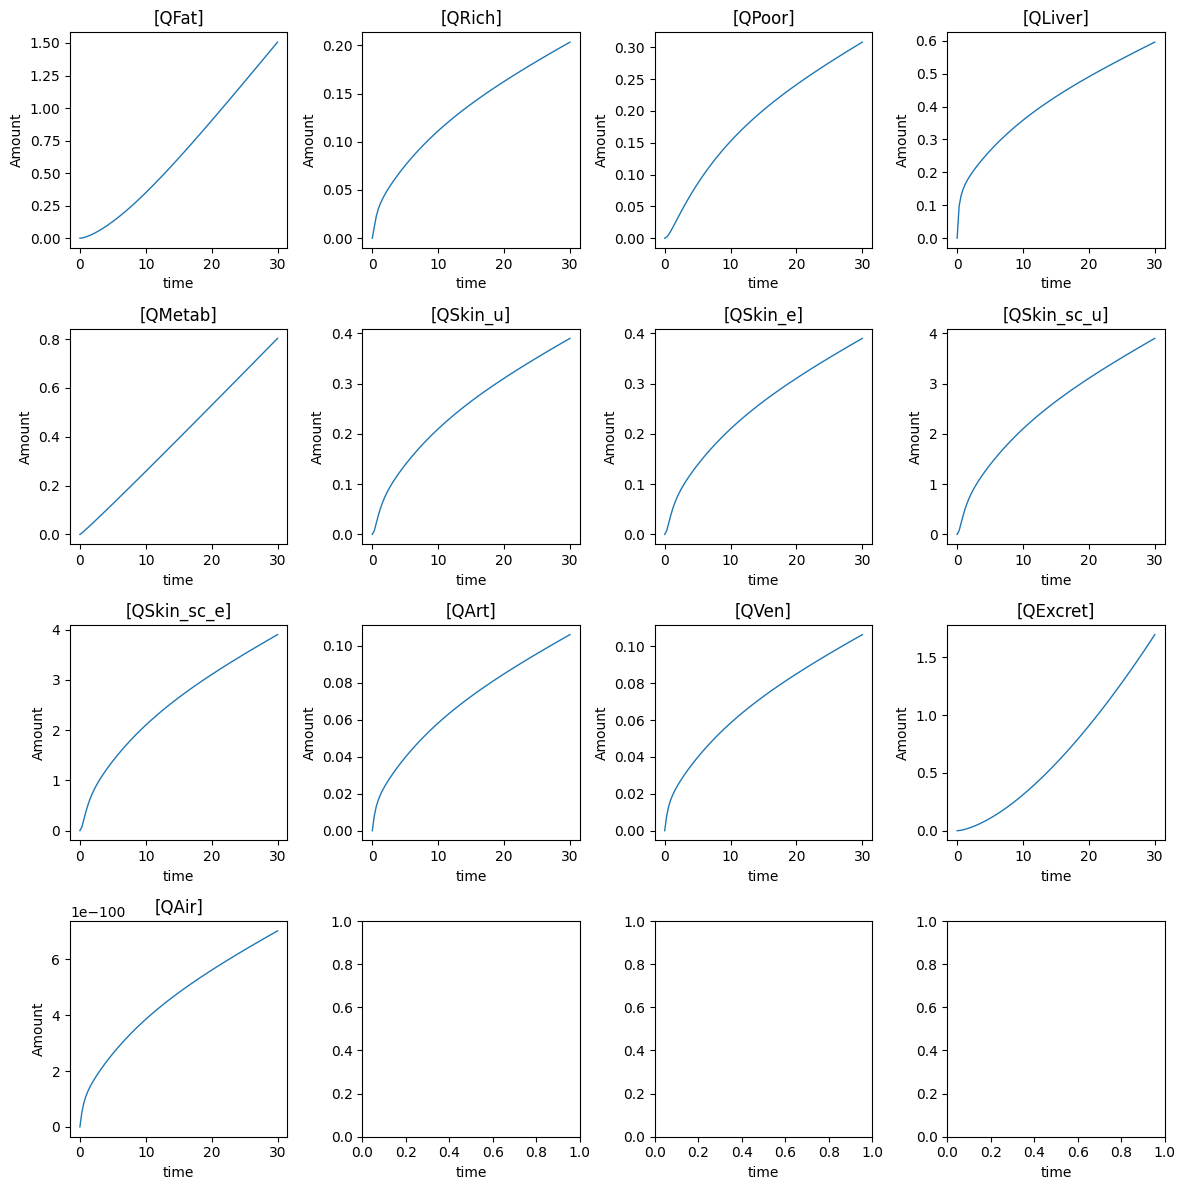

In [77]:
# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Set initial amount set constant and boundary for Gut
rr_model.setInitAmount(oral_input, 1)
rr_model.setConstant(oral_input, True)
rr_model.setBoundary(oral_input, True)

# Load parametrisation
loadParametrisation(rr_model, param_file, param_instance_id)

# Simulate the PBPK model
results = rr_model.simulate(start=0, end=30, points=100)

# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)

### Multiple oral dosing events

Bolus inputs fed to the model via events (one per day).

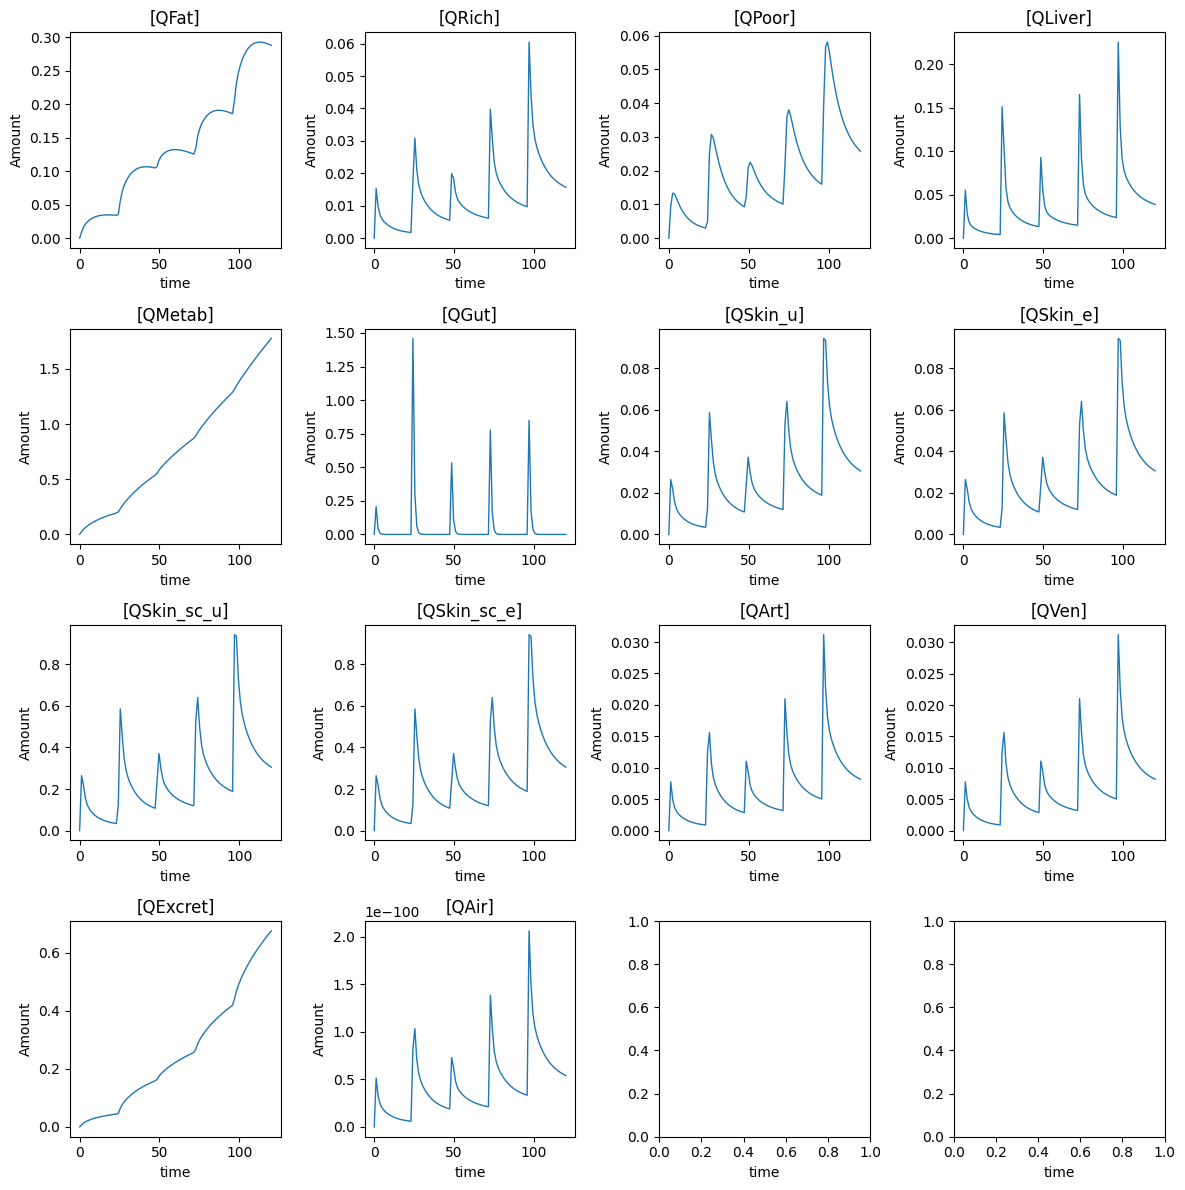

In [78]:
# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Make sure A_gut is not constant and does not have boundary conditions
rr_model.setInitAmount(oral_input, 0)
rr_model.setConstant(oral_input, False)
rr_model.setBoundary(oral_input, False)

# Remove all events
for event_id in rr_model.model.getEventIds():
    rr_model.removeEvent(event_id)

# Load parametrisation
loadParametrisation(rr_model, param_file, param_instance_id)

# Define a list of time/dose tuples
time_dose_list = [
    (0, 1), (24, 2), (48, 1), (72, 2), (96, 3)
]

# Create an event for each of the time-dose tuples
for i in range(0, len(time_dose_list)):
    dose_event = time_dose_list[i]
    eid = f"oral_dose_event_{i}"
    rr_model.addEvent(eid, False, f"time > {dose_event[0]}", False)
    rr_model.addEventAssignment(eid, oral_input, f"{oral_input} + {dose_event[1]}", False)
rr_model.regenerateModel(True, True)

# Simulate the PBPK model
results = rr_model.simulate(start=0, end=5*24, points=100)

# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)

### Multiple continuous oral input events

Continuous input events during 8 hours of the day over multiple days. Accomplished by setting the boundary condition to true.

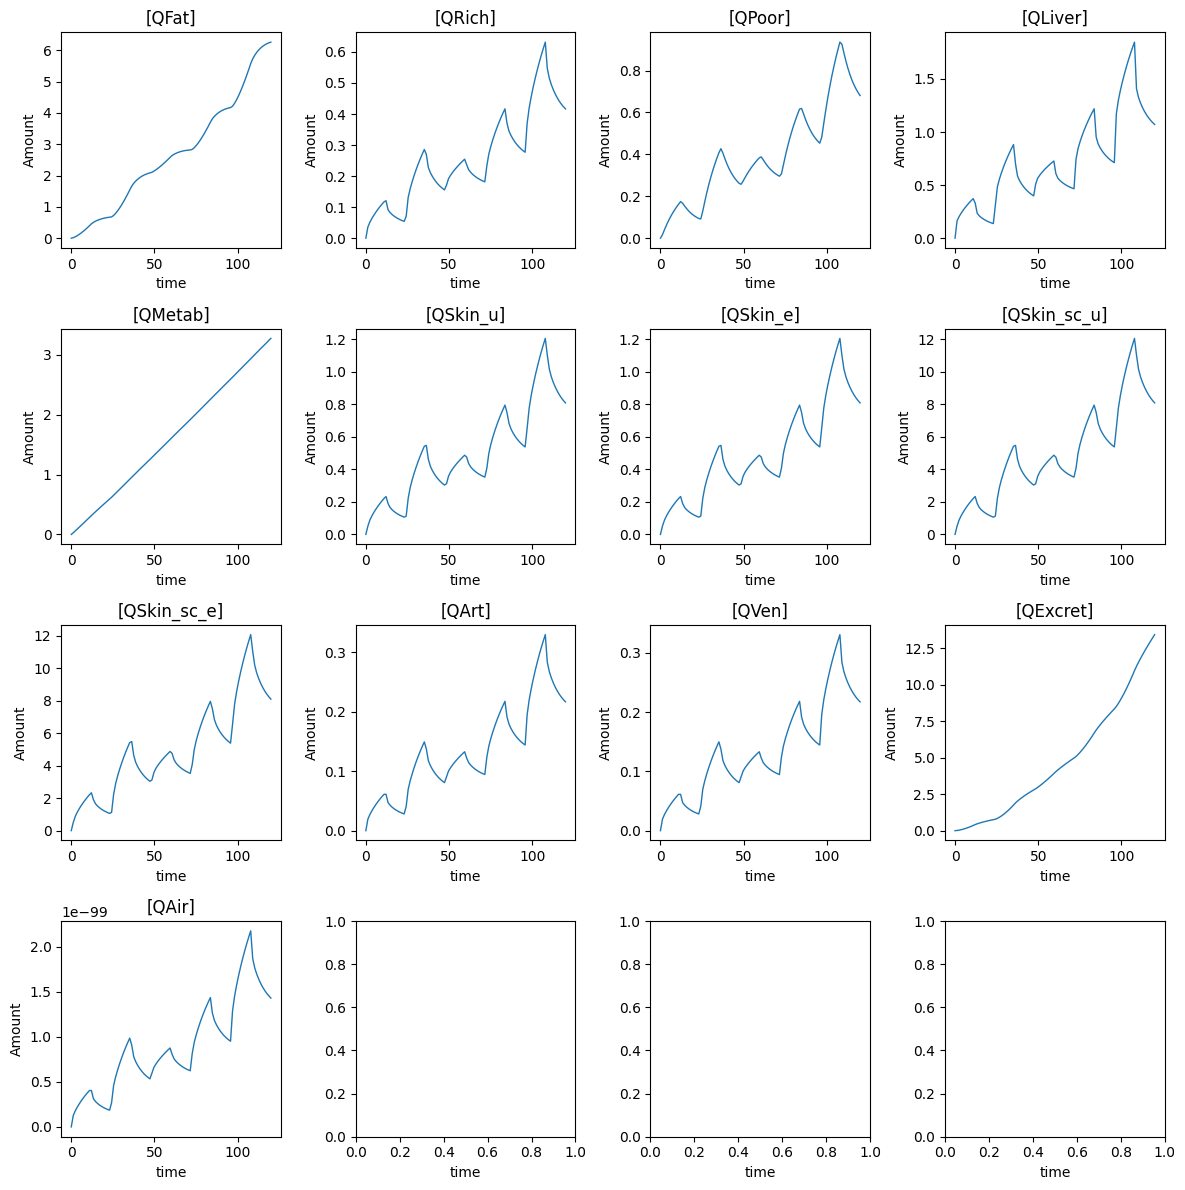

In [79]:
# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Make sure A_gut is not constant and does not have boundary conditions
rr_model.setInitAmount(oral_input, 0)
rr_model.setConstant(oral_input, False)
rr_model.setBoundary(oral_input, True)

# Remove all events
for event_id in rr_model.model.getEventIds():
    rr_model.removeEvent(event_id)

# Load parametrisation
loadParametrisation(rr_model, param_file, param_instance_id)

# Define a list of time/dose tuples
time_dose_duration_list = [
    (0, 1, 12),
    (24, 2, 12),
    (48, 1, 12),
    (72, 2, 12),
    (96, 3, 12)
]

# Create an event for each of the time-dose tuples
for i in range(0, len(time_dose_list)):
    dose_event = time_dose_duration_list[i]
    eid = f"oral_dose_event_{i}_start"
    rr_model.addEvent(eid, False, f"time > {dose_event[0]}", False)
    rr_model.addEventAssignment(eid, oral_input, f"{oral_input} + {dose_event[1]}", False)
    eid = f"oral_dose_event_{i}_stop"
    rr_model.addEvent(eid, False, f"time > {dose_event[0]} + {dose_event[2]}", False)
    rr_model.addEventAssignment(eid, oral_input, f"{oral_input} - {dose_event[1]}", False)
rr_model.regenerateModel(True, True)

# Simulate the PBPK model
results = rr_model.simulate(start=0, end=5*24, points=100)

# Plot the results

plotSimulationResults(results, rr_model.timeCourseSelections)

# Run for many days with oral daily bolus doses

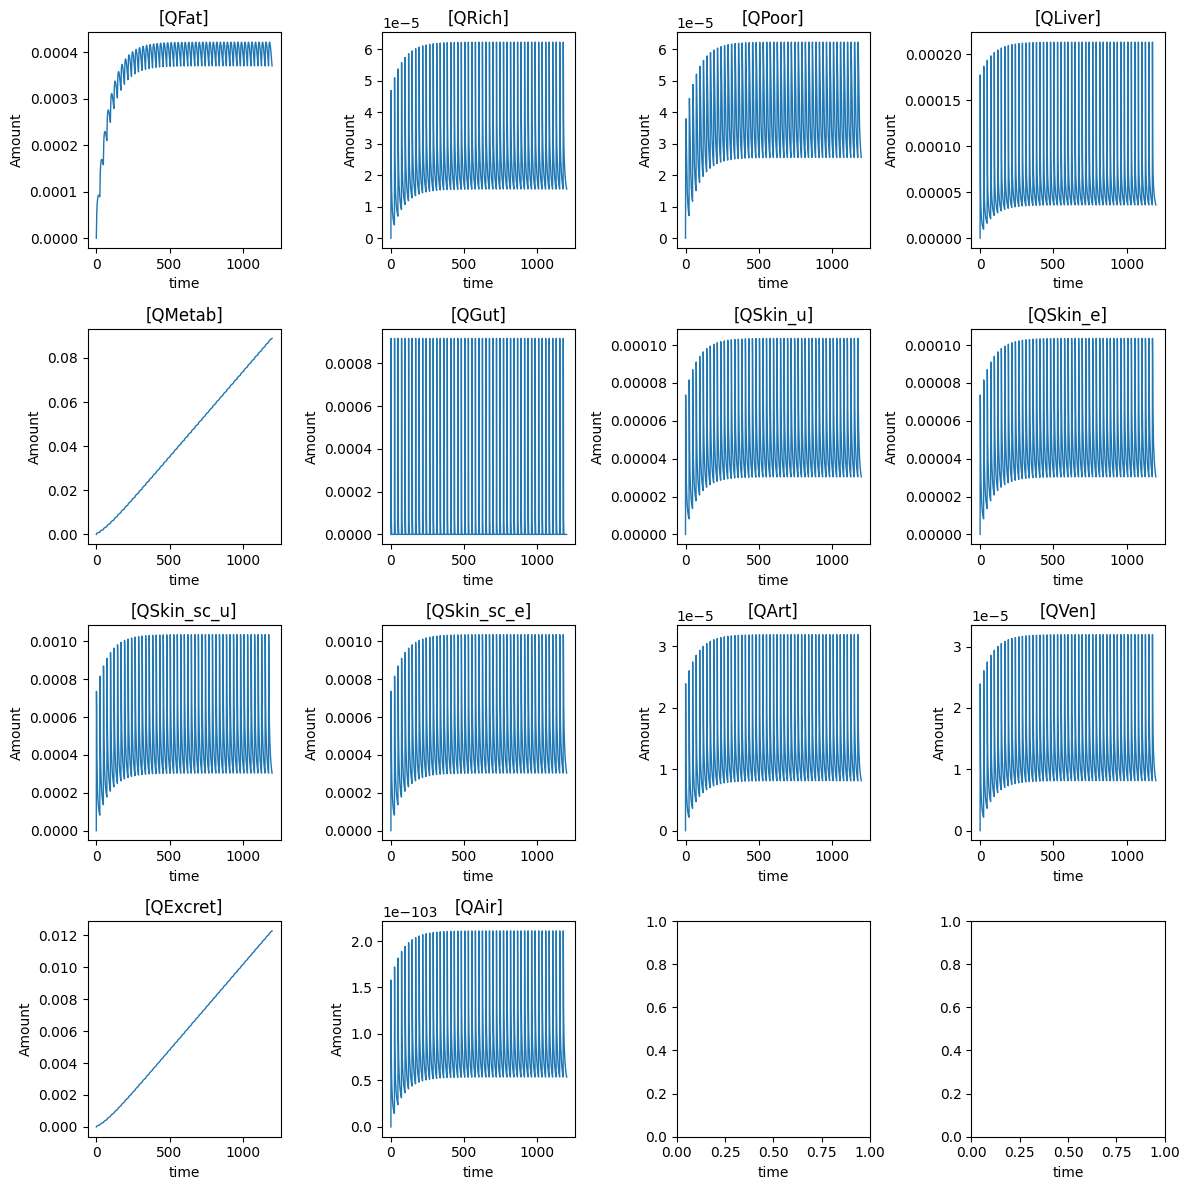

In [80]:
# Set daily dose (mg/kw/bw day) and number of simulated days
daily_dose = 0.02
number_of_days = 50

# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Make sure the input is not constant and does not have boundary conditions
rr_model.setInitAmount(oral_input, 0)
rr_model.setConstant(oral_input, False)
rr_model.setBoundary(oral_input, False)

# Remove all events
for event_id in rr_model.model.getEventIds():
    rr_model.removeEvent(event_id)

# Load parametrisation
loadParametrisation(rr_model, param_file, param_instance_id)

# Compute dose amount in mmol from daily dose
dose = daily_dose * rr_model['BM'] / molar_mass

# Define a list of time/dose tuples
time_dose_list = generateDoseEventsPattern(dose, 0, 24, 24 * number_of_days)

# Create an event for each of the time-dose tuples
for i in range(0, len(time_dose_list)):
    dose_event = time_dose_list[i]
    eid = f"oral_dose_event_{i}"
    rr_model.addEvent(eid, False, f"time > {dose_event[0]}", False)
    rr_model.addEventAssignment(eid, oral_input, f"{oral_input} + {dose_event[1]}", False)
rr_model.regenerateModel(True, True)

# Simulate the PBPK model
resolution = 1
results = rr_model.simulate(start=0, end=number_of_days*24, points=24 * number_of_days * resolution + 1)

# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections, 4)